## Evaluation of average models evaluated on each region of evaluate dataset
Using dataset average connectivity models, we evaluate regions in the eval_dataset separately


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import cortico_cereb_connectivity.globals as gl
import cortico_cereb_connectivity.run_model as rm
from statannotations.Annotator import Annotator
import Functional_Fusion.dataset as fdata
import Functional_Fusion.atlas_map as at
import glob
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
import SUITPy as suit
from itertools import combinations

In [2]:
def plot_cereb_data(data,cereb_atlas,cscale=[-0.1,0.1],colorbar=False):
    # Transform the data to a nifti image
    nifti_img = cereb_atlas.data_to_nifti(data)
    # Map to the cerebellar flatmap 
    flat_data = suit.flatmap.vol_to_surf(nifti_img)
    # Plot 
    suit.flatmap.plot(flat_data,new_figure=False,cscale=cscale, colorbar=colorbar)

### Using half estimation

In [5]:
dataset_list = ["MDTB", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC"]
df_all = pd.DataFrame()
for dataset_name in dataset_list:
    eval_data = [eval_ds for eval_ds in dataset_list if eval_ds != dataset_name]

    # Load region performances
    df = rm.comb_eval(models=[dataset_name+"-avg-halfregion"],methods=['L2reghalf'],eval_data=eval_data,cerebellum='MNISymC3')
    df['model'] = dataset_name+"-avg"
    df_all = pd.concat([df_all, df])

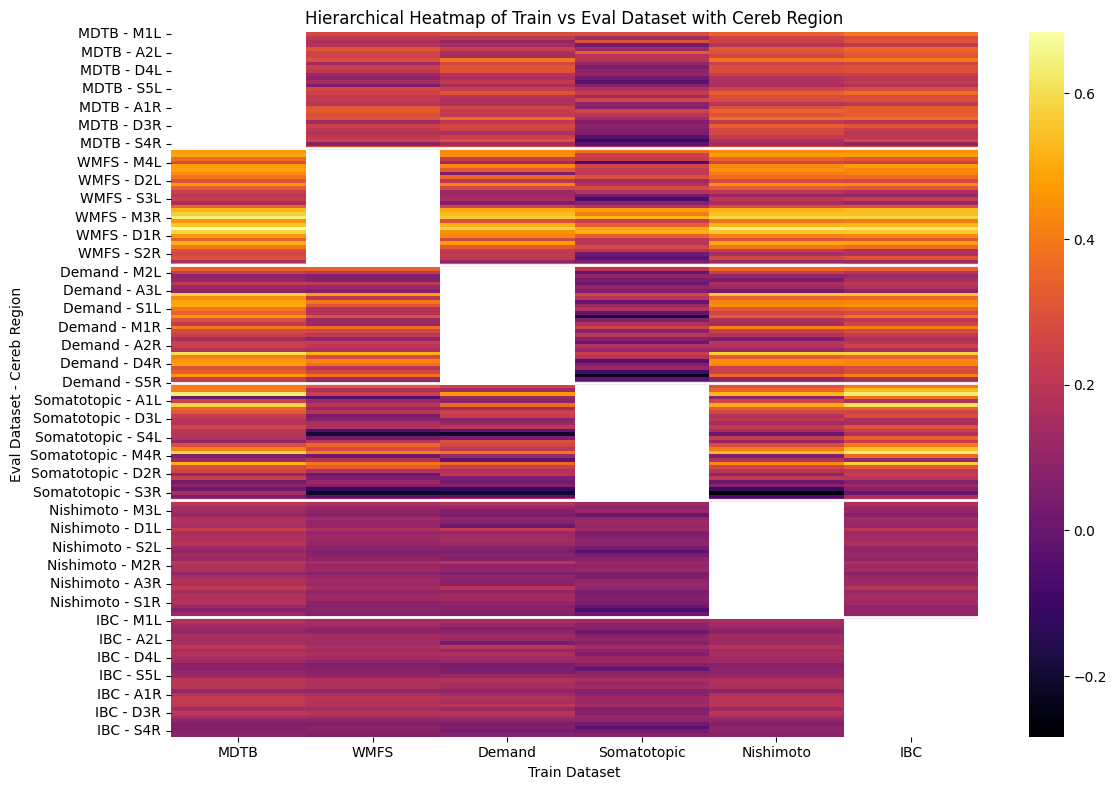

In [12]:
df_all['combined_index'] = df_all['eval_dataset'] + " - " + df_all['cereb_region_name']

# Pivot the data to create a hierarchical structure
heatmap_data = pd.pivot_table(df_all, values='R_eval', index='combined_index', columns='train_dataset')
heatmap_data = heatmap_data.reindex(index=[f"{eval_ds} - {region}" for eval_ds in dataset_list for region in df_all['cereb_region_name'].unique()],
                                    columns=dataset_list)

# Create the hierarchical heatmap
fig = plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='inferno', annot=False, fmt=".2f", cbar=True)

# Add horizontal lines where each eval_dataset ends
for i, eval_ds in enumerate(dataset_list[:-1]):
    end_index = df_all[df_all['eval_dataset'] == eval_ds]['combined_index'].iloc[-1]
    plt.axhline(y=heatmap_data.index.get_loc(end_index) + 0.5, color='white', linewidth=2)

# Customize the axes
plt.xlabel('Train Dataset')
plt.ylabel('Eval Dataset - Cereb Region')
plt.title('Hierarchical Heatmap of Train vs Eval Dataset with Cereb Region')
plt.tight_layout()
plt.show()

# fig.savefig('region_heatmap.png', dpi=300, bbox_inches='tight')

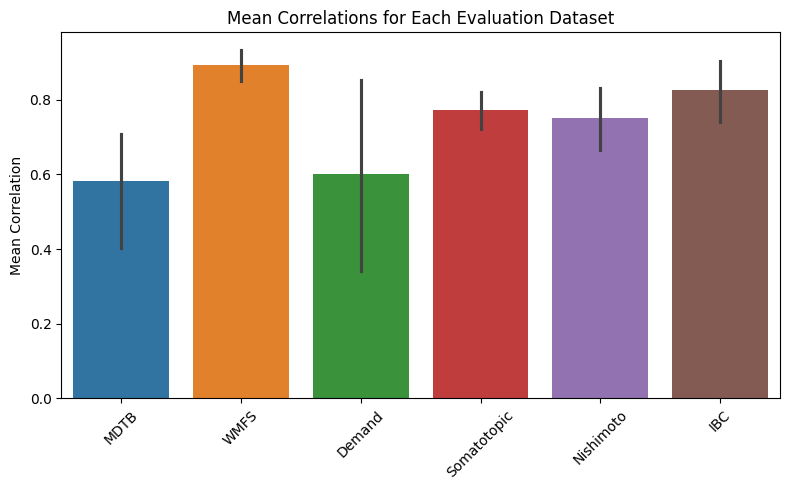

In [32]:
# Initialize a dictionary to store the mean correlations for each eval_dataset
mean_correlations = {}

# Iterate over each eval_dataset
for eval_ds in dataset_list:
    # Filter the heatmap_data for the current eval_dataset
    eval_data = heatmap_data.loc[heatmap_data.index.str.startswith(eval_ds)]
    eval_data = eval_data.drop(columns=[eval_ds], errors='ignore')
    
    # Extract the 32-length vectors for each train_dataset
    vectors = eval_data.T.values  # Transpose to get train_dataset as rows
    
    # Calculate correlations for all possible pairs of train datasets
    correlations = []
    for train_ds1, train_ds2 in combinations(range(vectors.shape[0]), 2):
        corr = np.corrcoef(vectors[train_ds1], vectors[train_ds2])[0, 1]
        correlations.append(corr)
    
    # Calculate the mean correlation for the current eval_dataset
    mean_correlations[eval_ds] = np.array(correlations)

# Create a DataFrame for the mean correlations
mean_corr_eval_df = pd.DataFrame(mean_correlations)
# Create a bar plot for the mean correlations
plt.figure(figsize=(8, 5))
sns.barplot(data=mean_corr_eval_df)
plt.ylabel('Mean Correlation')
plt.title('Mean Correlations for Each Evaluation Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

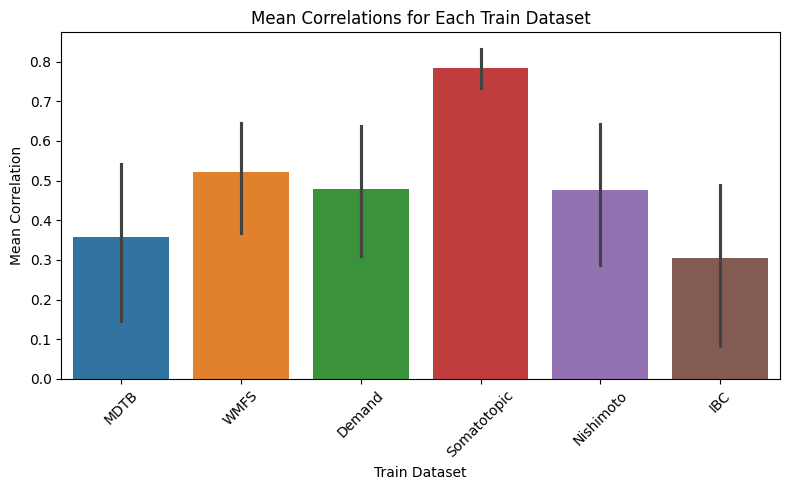

In [34]:
# Initialize a dictionary to store the mean correlations for each train_dataset
mean_correlations_train = {}

# Iterate over each train_dataset
for train_ds in dataset_list:
    # Filter the heatmap_data for the current train_dataset
    train_data = heatmap_data[train_ds]
    train_data = train_data[~train_data.index.str.startswith(train_ds)]
    vectors = train_data.values.reshape(-1, 32)  # Reshape to ensure correct dimensions
    
    # Calculate correlations for all possible pairs of eval datasets
    correlations = []
    for eval_ds1, eval_ds2 in combinations(range(vectors.shape[0]), 2):
        corr = np.corrcoef(vectors[eval_ds1], vectors[eval_ds2])[0, 1]
        correlations.append(corr)
    
    # Calculate the mean correlation for the current train_dataset
    mean_correlations_train[train_ds] = correlations

# Create a DataFrame for the mean correlations
mean_corr_train_df = pd.DataFrame(mean_correlations_train)
# Create a bar plot for the mean correlations for each train_dataset
plt.figure(figsize=(8, 5))
sns.barplot(data=mean_corr_train_df)
plt.xlabel('Train Dataset')
plt.ylabel('Mean Correlation')
plt.title('Mean Correlations for Each Train Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Average performance on regions

In [13]:
atlas, _ = at.get_atlas('MNISymC3')
atlas_dir = '/cifs/diedrichsen/data/FunctionalFusion/Atlases/tpl-MNI152NLin2009cSymC'
atlas_fname = 'atl-NettekovenSym32_space-MNI152NLin2009cSymC_probseg.nii'
U = atlas.read_data(f'{atlas_dir}/{atlas_fname}').T
atlas_labels = np.argmax(U, axis=1)+1

In [14]:
# Group by train_dataset and cereb_region_name, then calculate the mean of R_eval
average_r_eval = df_all.groupby(['train_dataset', 'cereb_region_num'])['R_eval'].mean().unstack().reindex(dataset_list)

# Create a dictionary to store the vectors for each train_dataset
R_map_dic = {}
for train_dataset in average_r_eval.index:
    vector = np.zeros(len(atlas_labels))
    for i, label in enumerate(atlas_labels):
        if label in average_r_eval.columns:
            vector[i] = average_r_eval.loc[train_dataset, label]
    R_map_dic[train_dataset] = vector

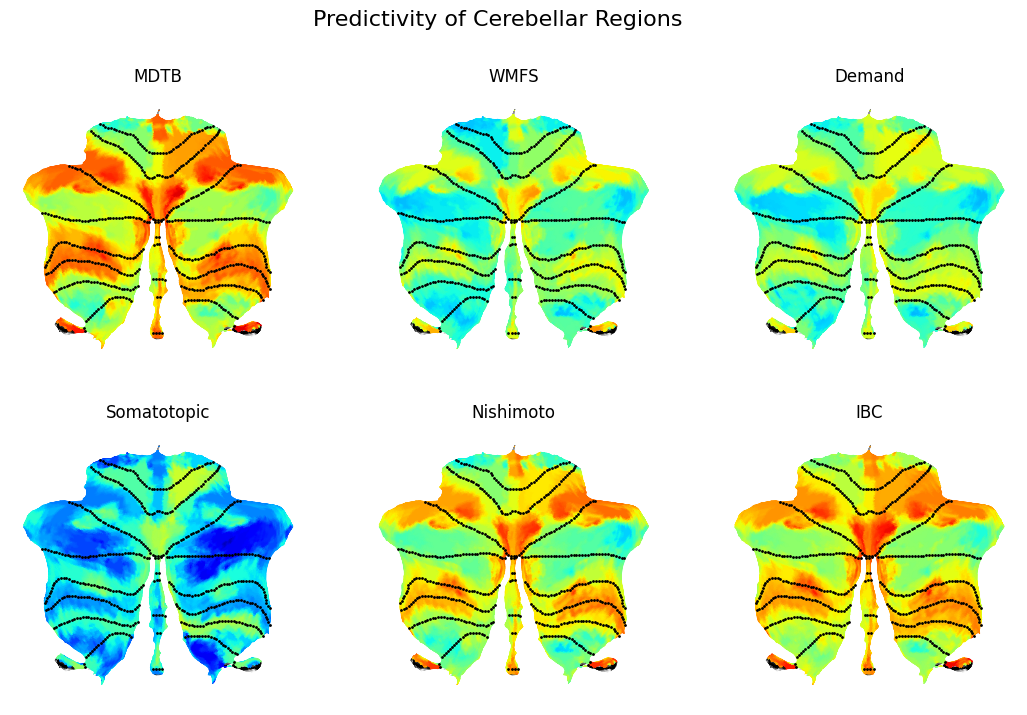

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(13, 8))
plt.suptitle('Predictivity of Cerebellar Regions', fontsize=16)
for i, (dataset_name, R_map) in enumerate(R_map_dic.items()):
    plt.subplot(2, 3, i + 1)
    plot_cereb_data(R_map, atlas, cscale=[-0.1, 0.5])
    plt.title(dataset_name)
# fig.savefig('predictivity_region.png', dpi=300, bbox_inches='tight')

In [16]:
# Group by eval_dataset and cereb_region_name, then calculate the mean of R_eval
average_r_eval = df_all.groupby(['eval_dataset', 'cereb_region_num'])['R_eval'].mean().unstack().reindex(dataset_list)

# Create a dictionary to store the vectors for each eval_dataset
R_map_dic = {}
for eval_dataset in average_r_eval.index:
    vector = np.zeros(len(atlas_labels))
    for i, label in enumerate(atlas_labels):
        if label in average_r_eval.columns:
            vector[i] = average_r_eval.loc[eval_dataset, label]
    R_map_dic[eval_dataset] = vector

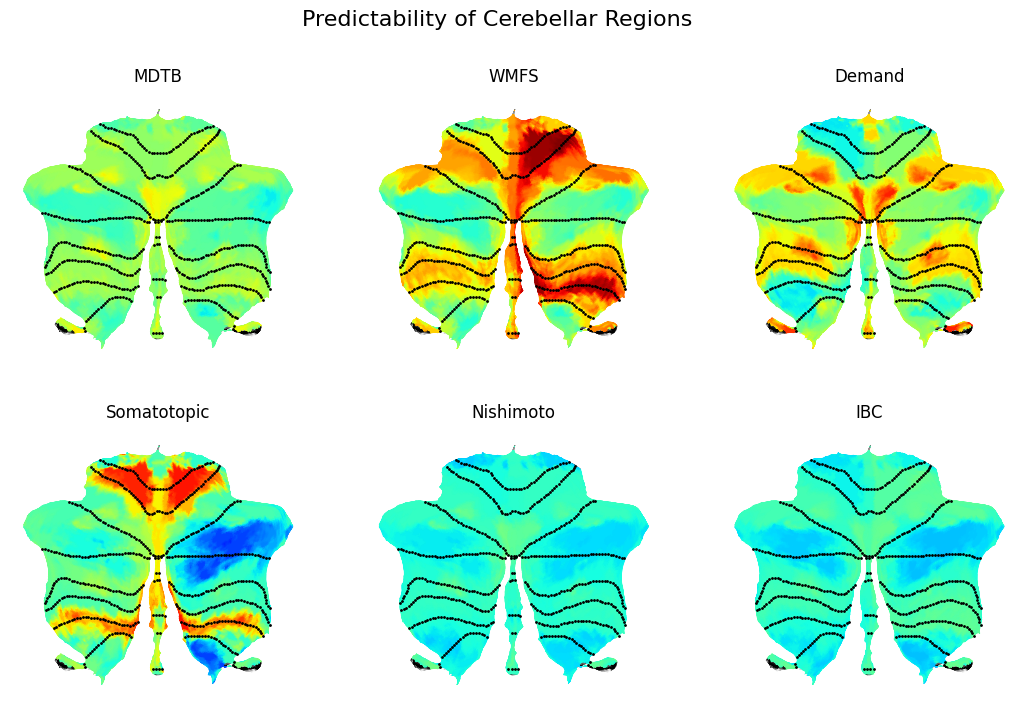

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(13, 8))
plt.suptitle('Predictability of Cerebellar Regions', fontsize=16)
for i, (dataset_name, R_map) in enumerate(R_map_dic.items()):
    plt.subplot(2, 3, i + 1)
    plot_cereb_data(R_map, atlas, cscale=[-0.2, 0.6])
    plt.title(dataset_name)
# fig.savefig('predictability_region.png', dpi=300, bbox_inches='tight')

### Replication with L2reg

In [35]:
dataset_list = ["MDTB", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC"]
df_all = pd.DataFrame()
for dataset_name in dataset_list:
    eval_data = [eval_ds for eval_ds in dataset_list if eval_ds != dataset_name]

    # Load region performances
    df = rm.comb_eval(models=[dataset_name+"-avgregion"],methods=['L2reg'],eval_data=eval_data,cerebellum='MNISymC3')
    df['model'] = dataset_name+"-avg"
    df_all = pd.concat([df_all, df])

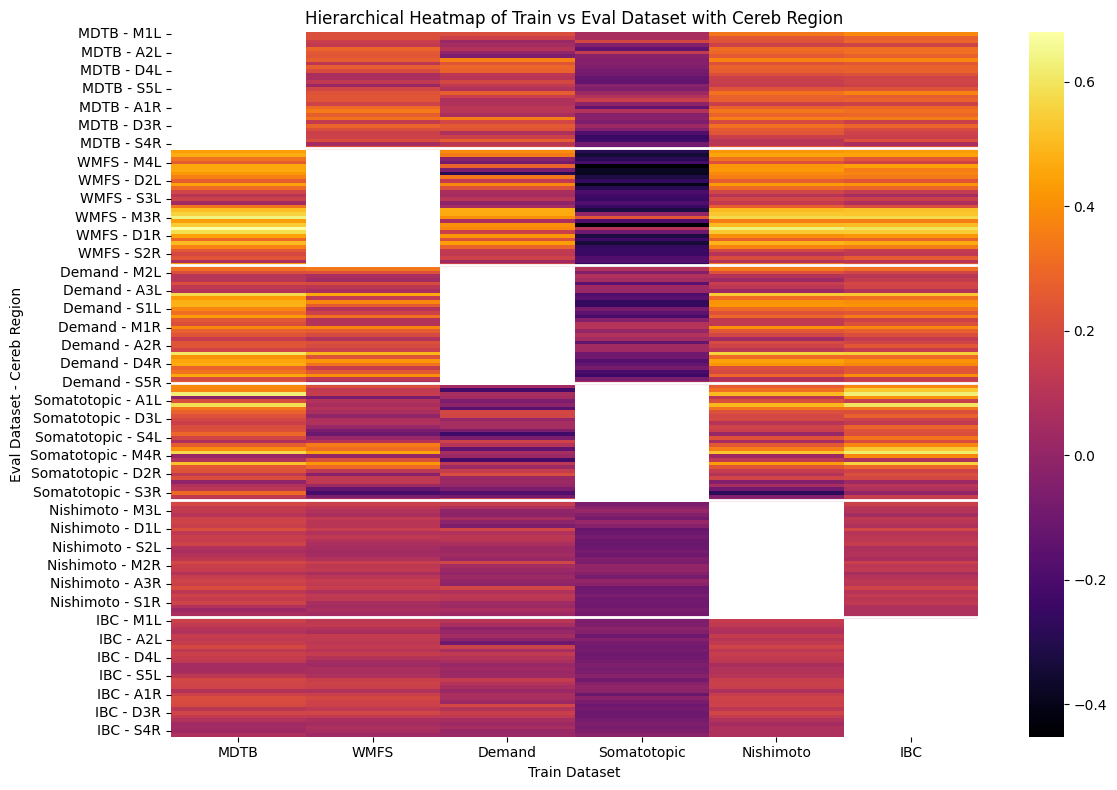

In [36]:
df_all['combined_index'] = df_all['eval_dataset'] + " - " + df_all['cereb_region_name']

# Pivot the data to create a hierarchical structure
heatmap_data = pd.pivot_table(df_all, values='R_eval', index='combined_index', columns='train_dataset')
heatmap_data = heatmap_data.reindex(index=[f"{eval_ds} - {region}" for eval_ds in dataset_list for region in df_all['cereb_region_name'].unique()],
                                    columns=dataset_list)

# Create the hierarchical heatmap
fig = plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='inferno', annot=False, fmt=".2f", cbar=True)

# Add horizontal lines where each eval_dataset ends
for i, eval_ds in enumerate(dataset_list[:-1]):
    end_index = df_all[df_all['eval_dataset'] == eval_ds]['combined_index'].iloc[-1]
    plt.axhline(y=heatmap_data.index.get_loc(end_index) + 0.5, color='white', linewidth=2)

# Customize the axes
plt.xlabel('Train Dataset')
plt.ylabel('Eval Dataset - Cereb Region')
plt.title('Hierarchical Heatmap of Train vs Eval Dataset with Cereb Region')
plt.tight_layout()
plt.show()

In [37]:
# Group by train_dataset and cereb_region_name, then calculate the mean of R_eval
average_r_eval = df_all.groupby(['train_dataset', 'cereb_region_num'])['R_eval'].mean().unstack().reindex(dataset_list)

# Create a dictionary to store the vectors for each train_dataset
R_map_dic = {}
for train_dataset in average_r_eval.index:
    vector = np.zeros(len(atlas_labels))
    for i, label in enumerate(atlas_labels):
        if label in average_r_eval.columns:
            vector[i] = average_r_eval.loc[train_dataset, label]
    R_map_dic[train_dataset] = vector

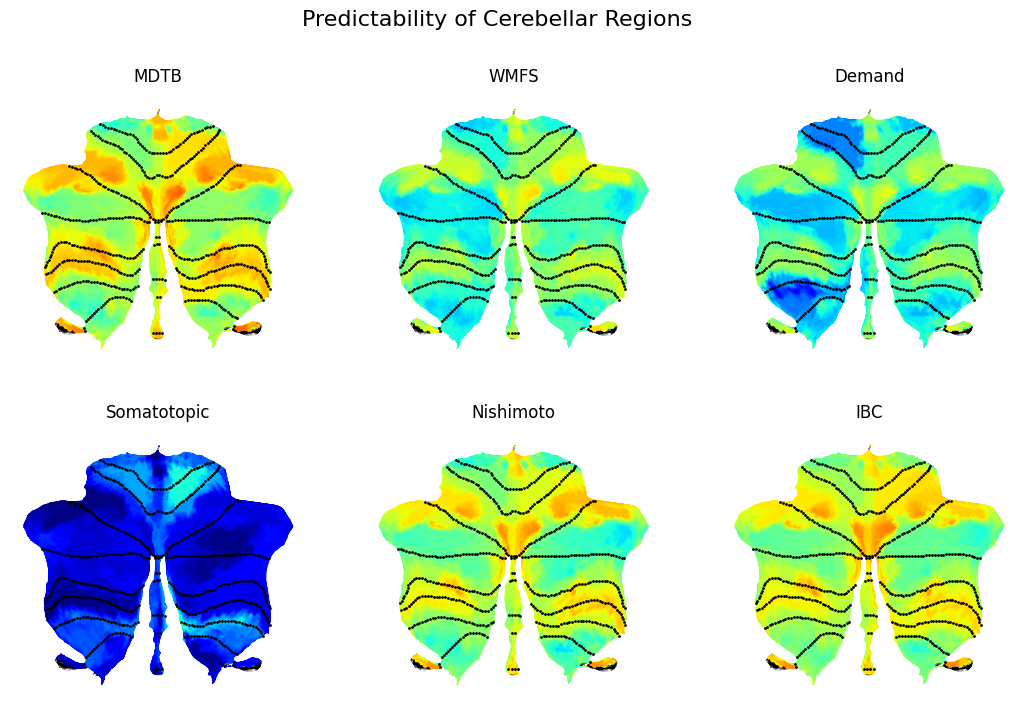

In [38]:
fig, axes = plt.subplots(2, 3, figsize=(13, 8))
plt.suptitle('Predictability of Cerebellar Regions', fontsize=16)
for i, (dataset_name, R_map) in enumerate(R_map_dic.items()):
    plt.subplot(2, 3, i + 1)
    plot_cereb_data(R_map, atlas, cscale=[-0.2, 0.6])
    plt.title(dataset_name)

In [39]:
# Group by eval_dataset and cereb_region_name, then calculate the mean of R_eval
average_r_eval = df_all.groupby(['eval_dataset', 'cereb_region_num'])['R_eval'].mean().unstack().reindex(dataset_list)

# Create a dictionary to store the vectors for each eval_dataset
R_map_dic = {}
for eval_dataset in average_r_eval.index:
    vector = np.zeros(len(atlas_labels))
    for i, label in enumerate(atlas_labels):
        if label in average_r_eval.columns:
            vector[i] = average_r_eval.loc[eval_dataset, label]
    R_map_dic[eval_dataset] = vector

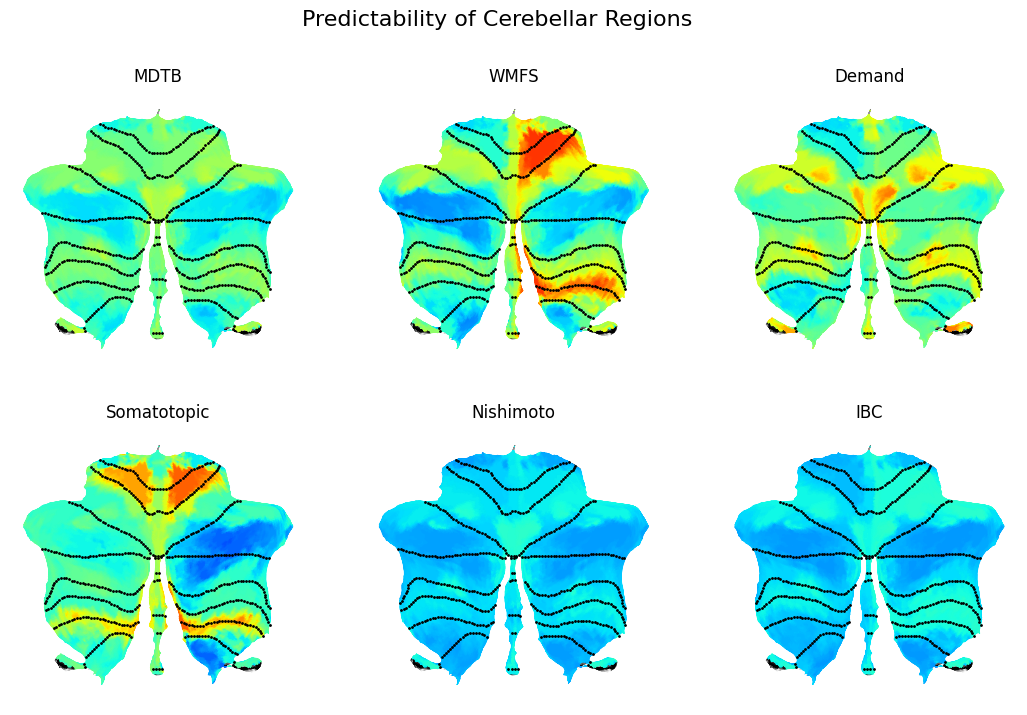

In [40]:
fig, axes = plt.subplots(2, 3, figsize=(13, 8))
plt.suptitle('Predictability of Cerebellar Regions', fontsize=16)
for i, (dataset_name, R_map) in enumerate(R_map_dic.items()):
    plt.subplot(2, 3, i + 1)
    plot_cereb_data(R_map, atlas, cscale=[-0.2, 0.6])
    plt.title(dataset_name)